# Optimization

In this notebook, we explore how the TODO

## Data and Model

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

Load and process MNIST dataset.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), _ = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('int32')
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.batch(64)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, 'relu'),
        tf.keras.layers.Dense(64, 'relu'),
        tf.keras.layers.Dense(32, 'relu'),
        tf.keras.layers.Dense(10),
    ])

    # model = tf.keras.Sequential([
    #     tf.keras.layers.Conv2D(32, 3),
    #     tf.keras.layers.ReLU(),
    #     tf.keras.layers.Conv2D(64, 3),
    #     tf.keras.layers.ReLU(),
    #     tf.keras.layers.MaxPool2D((2, 2)),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(128, 'relu'),
    #     tf.keras.layers.Dense(10),
    # ])

    # Build the model
    x_batch = tf.random.uniform([128, 28, 28])
    _ = model(x_batch)

    return model


def get_num_params(model):
    num_params = 0
    for v in init_model.variables:
        num_params += tf.reduce_prod(tf.shape(v)).numpy()
    return num_params


def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    for i, var in enumerate(model.variables):
        new_model.variables[i].assign(var)
    return new_model


init_model = build_model()
get_num_params(init_model)

111146

Then define loss and functions for training.

In [4]:
def cross_entropy_loss(logits, labels):
    """Compute cross entropy loss with a sparse operation."""
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels)
    return tf.reduce_mean(sparse_ce)


def train_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss_batch = cross_entropy_loss(y_pred, y_batch)
    grads = tape.gradient(loss_batch, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss_batch

In [5]:
def test(model, optimizer, epochs=5):
    # Initializations.
    loss_values = []

    # Training process.
    for epoch in range(epochs):
        ds_iter = ds_train.as_numpy_iterator()
        while True:
            try:
                x_batch, y_batch = next(ds_iter)
            except StopIteration:
                break
            loss_batch = train_step(model, optimizer, x_batch, y_batch)
            loss_values.append(loss_batch.numpy())
            if np.isnan(loss_values[-1]):
                raise ValueError('NaN')
        print(f'epoch = {epoch}, loss = {np.mean(loss_values[-200:])}')

    print(f'Final loss = {np.mean(loss_values[-200:])}')
    plt.plot(loss_values)
    plt.title('Training loss.')
    plt.show()
    return loss_values, model, optimizer

In [26]:
class Adam(tf.Module):

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads_and_vars):
      grads_and_vars = list(grads_and_vars)

      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for _, var in grads_and_vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(grads_and_vars):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
        # Bias correction
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        # Update model variables
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      # Increment the iteration counter
      self.t += 1.

epoch = 0, loss = 0.170563206076622
epoch = 1, loss = 0.10958357155323029
epoch = 2, loss = 0.07896944880485535
epoch = 3, loss = 0.05905643478035927
epoch = 4, loss = 0.043518487364053726
Final loss = 0.043518487364053726


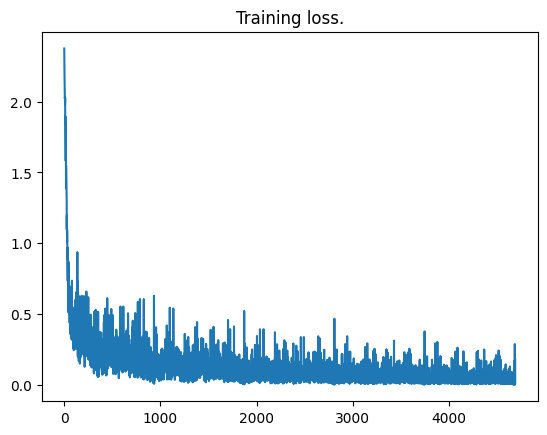

In [27]:
_ = test(clone_model(init_model), Adam())

In [28]:
class SimpleAdam(tf.Module):

    def __init__(self, learning_rate=1e-4, decay_factor=0.95):
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.smeared_grads = []
        self.built = False

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)
        if not self.built:
            for _, var in grads_and_vars:
                self.smeared_grads.append(tf.Variable(tf.zeros(shape=var.shape)))
            self.built = True
        # Perform Adam updates
        for i, (grad, var) in enumerate(grads_and_vars):
            smeared_grad = self.smeared_grads[i]
            smeared_grad.assign(
                self.decay_factor * smeared_grad
                + (1-self.decay_factor) * grad
            )
            var.assign_sub(self.learning_rate*(tf.math.sign(smeared_grad)))

epoch = 0, loss = 0.19380377233028412
epoch = 1, loss = 0.12108686566352844
epoch = 2, loss = 0.08444467186927795
epoch = 3, loss = 0.06350532174110413
epoch = 4, loss = 0.04931699112057686
Final loss = 0.04931699112057686


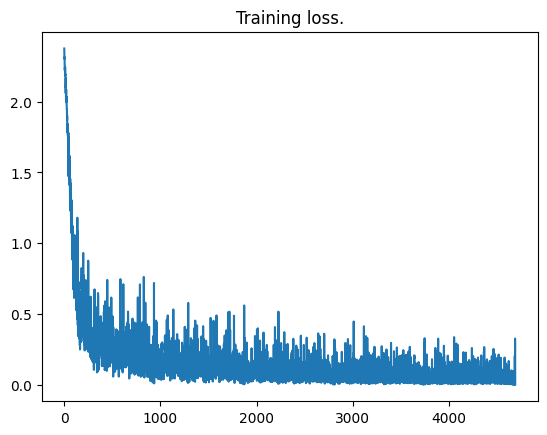

In [29]:
_ = test(clone_model(init_model), SimpleAdam(learning_rate=2e-4))

epoch = 0, loss = 0.1414172351360321
epoch = 1, loss = 0.08803374320268631
epoch = 2, loss = 0.06065753474831581
epoch = 3, loss = 0.044155701994895935
epoch = 4, loss = 0.033701490610837936
Final loss = 0.033701490610837936


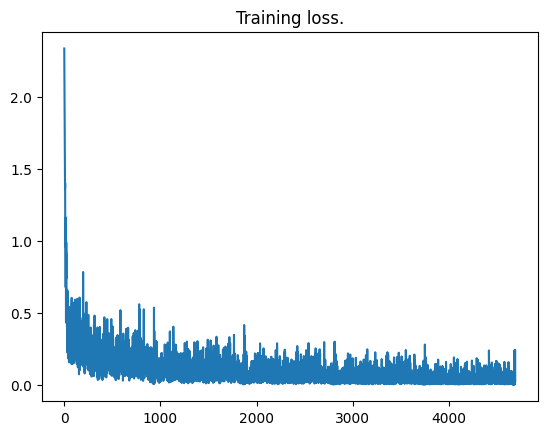

In [ ]:
_ = test(clone_model(init_model), Adam())

In [ ]:
class LayerwiseAdam(tf.Module):

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads_and_vars):
      grads_and_vars = list(grads_and_vars)

      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for _, var in grads_and_vars:
          v = tf.Variable(tf.zeros(tf.shape(var)))
          s = tf.Variable(0.)
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(grads_and_vars):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.reduce_mean(tf.square(d_var))
        # Update model variables
        var.assign_sub(self.learning_rate*self.v_dvar[i]/(tf.sqrt(self.s_dvar[i]) + self.ep))

epoch = 0, loss = 0.15203005075454712
epoch = 1, loss = 0.10121890902519226
epoch = 2, loss = 0.0829693004488945
epoch = 3, loss = 0.06832142174243927
epoch = 4, loss = 0.057024117559194565
Final loss = 0.057024117559194565


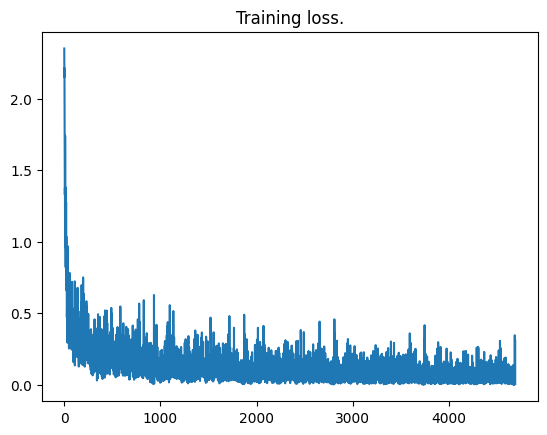

In [ ]:
_ = test(clone_model(init_model), LayerwiseAdam())

In [ ]:
class BBOptimizer(tf.Module):

    def __init__(self, learning_rate=1.0, momentum=0.9, rms=0.9, epsilon=1e-7, debug=False):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rms = rms
        self.epsilon = epsilon
        self.debug = debug

        self.dx_rms = []
        self.dg_rms = []
        self.dx = []  # the smeared \Delta x (x for variable).
        self.g = []  # the smeared g (gradient).
        self.built = False

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)

        # Build the optimizer if `self.build` is `False`.
        if not self.built:
            for grad, var in grads_and_vars:
                self.dx_rms.append(tf.Variable(1.))
                self.dg_rms.append(tf.Variable(1.))
                self.dx.append(tf.Variable(tf.zeros(tf.shape(var))))
                self.g.append(tf.Variable(tf.zeros(tf.shape(var))))
            self.built = True

        for i, (g, x) in enumerate(grads_and_vars):
            # \Delta g
            dg = (1 - self.momentum) * (g - self.g[i])

            # Update self.g
            self.g[i] = self.momentum * self.g[i] + (1-self.momentum) * g

            # Update self.dg_rms
            dg_dg = tf.reduce_mean(dg * dg)
            self.dg_rms[i] = self.rms * self.dg_rms[i] + (1-self.rms) * dg_dg

            # BB's \alpha-factor
            bb_factor = (self.dx_rms[i] + self.epsilon) / (self.dg_rms[i] + self.epsilon)
            if self.debug:
                print('bb', i, self.dx_rms[i].numpy(), self.dg_rms[i].numpy(), bb_factor.numpy())

            # Update self.dx
            self.dx[i] = -self.learning_rate * bb_factor * self.g[i]

            # Update self.dx_rms
            dg_dx = tf.reduce_mean(dg * self.dx[i])
            self.dx_rms[i] = self.rms * self.dx_rms[i] + (1-self.rms) * dg_dx

            # Update trainable parameter.
            x.assign_add(self.dx[i])

Let us train a model.

epoch = 0, loss = 0.17365072667598724
epoch = 1, loss = 0.12161166965961456
epoch = 2, loss = 0.09132968634366989
epoch = 3, loss = 0.07613237202167511
epoch = 4, loss = 0.05981605499982834
Final loss = 0.05981605499982834


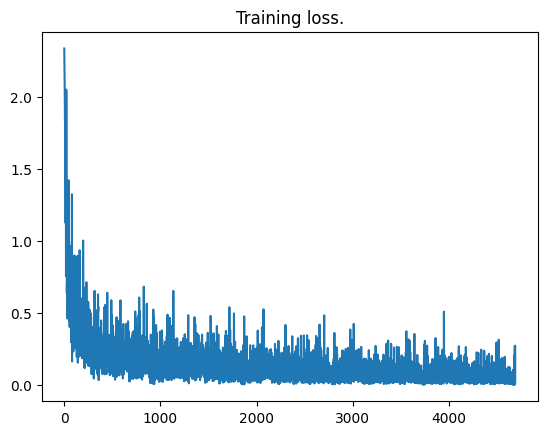

In [ ]:
_ = test(clone_model(init_model), BBOptimizer())

In [ ]:
class ImprovedBBOptimizer(tf.Module):

    def __init__(self, learning_rate=1.0, momentum=0.9, rms=0.9, epsilon=1e-7, debug=False):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rms = rms
        self.epsilon = epsilon
        self.debug = debug

        self.dx_rms = []
        self.dg_rms = []
        self.gdx_rms = []
        self.dx = []  # the smeared \Delta x (x for variable).
        self.g = []  # the smeared g (gradient).
        self.built = False

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)

        # Build the optimizer if `self.build` is `False`.
        if not self.built:
            for grad, var in grads_and_vars:
                self.gdx_rms.append(tf.Variable(0.))
                self.dx_rms.append(tf.Variable(1.))
                self.dg_rms.append(tf.Variable(1.))
                self.dx.append(tf.Variable(tf.zeros(tf.shape(var))))
                self.g.append(tf.Variable(tf.zeros(tf.shape(var))))
            self.built = True

        for i, (g, x) in enumerate(grads_and_vars):
            # \Delta g
            dg = (1 - self.momentum) * (g - self.g[i])

            # Update self.g
            self.g[i] = self.momentum * self.g[i] + (1-self.momentum) * g

            # Update self.dg_rms
            dg_dg = tf.reduce_mean(dg * dg)
            self.dg_rms[i] = self.rms * self.dg_rms[i] + (1-self.rms) * dg_dg

            # BB's \alpha-factor
            bb_factor = (self.dx_rms[i] + self.epsilon) / (self.dg_rms[i] + self.epsilon)
            if self.debug:
                print('bb', i, self.dx_rms[i].numpy(), self.dg_rms[i].numpy(), bb_factor.numpy())

            # Update self.dx
            g_dx = tf.reduce_mean(self.g[i] * self.dx[i])
            self.gdx_rms[i] = self.rms * self.gdx_rms[i] + (1-self.rms) * g_dx
            t = (self.gdx_rms[i] + self.epsilon) / (self.dx_rms[i] + self.epsilon)

            if self.debug:
                print('bb-3', self.gdx_rms[i].numpy(), t.numpy())
            self.dx[i] = -self.learning_rate * bb_factor * (self.g[i] - t*dg) - t*self.dx[i]

            # Update self.dx_rms
            dg_dx = tf.reduce_mean(dg * self.dx[i])
            self.dx_rms[i] = self.rms * self.dx_rms[i] + (1-self.rms) * dg_dx

            # Update trainable parameter.
            x.assign_add(self.dx[i])

In [ ]:
_ = test(clone_model(init_model), ImprovedBBOptimizer())

ValueError: NaN

In [ ]:
class ElementwiseBBOptimizer(tf.Module):

    def __init__(self, learning_rate=1.0, momentum=0.9, rms=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rms = rms
        self.epsilon = epsilon

        self.dx_rms = []
        self.dg_rms = []
        self.dx = []  # the smeared \Delta x (x for variable).
        self.g = []  # the smeared g (gradient).
        self.built = False

    def rms_update(self, x, new_x):
        x.assign(self.rms * x + (1-self.rms) * tf.square(new_x))

    def safe_div(self, x, y):
        return (x + self.epsilon) / (y + self.epsilon)

    def apply_gradients(self, grads_and_vars):
        grads_and_vars = list(grads_and_vars)

        # Build the optimizer if `self.build` is `False`.
        if not self.built:
            for grad, var in grads_and_vars:
                self.dx_rms.append(tf.Variable(tf.ones(tf.shape(var))))
                self.dg_rms.append(tf.Variable(tf.ones(tf.shape(var))))
                self.dx.append(tf.Variable(tf.zeros(tf.shape(var))))
                self.g.append(tf.Variable(tf.zeros(tf.shape(var))))
            self.built = True

        for i, (g, x) in enumerate(grads_and_vars):
            # \Delta g
            dg = (1 - self.momentum) * (g - self.g[i])

            # Update self.g
            self.g[i] = self.momentum * self.g[i] + (1-self.momentum) * g

            # Update self.dg_rms
            self.rms_update(self.dg_rms[i], dg)

            # BB's \alpha-factor
            bb_factor = self.safe_div(tf.sqrt(self.dx_rms[i]), tf.sqrt(self.dg_rms[i]))

            # Update self.dx
            self.dx[i] = -self.learning_rate * bb_factor * self.g[i]

            # Update self.dx_rms
            self.rms_update(self.dx_rms[i], self.dx[i])

            # Update trainable parameter.
            x.assign_add(self.dx[i])

In [ ]:
_ = test(clone_model(init_model), ElementwiseBBOptimizer())

epoch = 0, loss = 195811246080.0


ValueError: NaN